In [ ]:
!pip install librosa==0.9.2

# Install Git LFS (needed for .wav files)
!apt-get install git-lfs -y
!git lfs install

# Clone repo
!git clone https://github.com/gveres/donateacry-corpus.git

# Pull large audio files (wav)
%cd donateacry-corpus
!git lfs pull
%cd /content


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
fatal: destination path 'donateacry-corpus' already exists and is not an empty directory.
/content/donateacry-corpus
/content


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def create_pngs_from_wavs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if fname.endswith(".wav"):
            wav_path = os.path.join(input_dir, fname)
            png_path = os.path.join(output_dir, fname.replace(".wav", ".png"))

            y, sr = librosa.load(wav_path, sr=None)
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            plt.figure(figsize=(6, 4))
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
            plt.axis("off")
            plt.savefig(png_path, bbox_inches="tight", pad_inches=0)
            plt.close()


In [ ]:
base_path = "/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data"
output_base = "/content/processed"

categories = ["belly_pain", "burping", "discomfort", "hungry", "tired"]

for cat in categories:
    in_dir = os.path.join(base_path, cat)
    out_dir = os.path.join(output_base, cat)
    create_pngs_from_wavs(in_dir, out_dir)
    print(f"Done: {cat}")


Done: belly_pain
Done: burping
Done: discomfort
Done: hungry
Done: tired


In [ ]:
def load_images_from_path(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        if file.endswith(".png"):
            img = image.load_img(os.path.join(path, file), target_size=(224, 224))
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load all categories
x, y = [], []
for idx, cat in enumerate(categories):
    img_dir = os.path.join(output_base, cat)
    imgs, labels = load_images_from_path(img_dir, idx)
    x.extend(imgs)
    y.extend(labels)

x = np.array(x)
y = np.array(y)

print("Loaded data:")
print("X shape:", x.shape)
print("Y shape:", y.shape)


Loaded data:
X shape: (457, 224, 224, 3)
Y shape: (457,)


In [ ]:
# Ensure numpy arrays
x = np.array(x)
y = np.array(y)

# Split train/test with stratify
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=0, stratify=y
)

# Normalize pixel values
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y)))

print("Shapes:")
print("x_train_norm:", x_train_norm.shape)
print("x_test_norm:", x_test_norm.shape)
print("y_train_encoded:", y_train_encoded.shape)
print("y_test_encoded:", y_test_encoded.shape)


Shapes:
x_train_norm: (411, 224, 224, 3)
x_test_norm: (46, 224, 224, 3)
y_train_encoded: (411, 5)
y_test_encoded: (46, 5)


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization, Resizing, InputLayer
from tensorflow.keras.optimizers import AdamW

class RandomFourierFeatures(tf.keras.layers.Layer):
    def __init__(self, output_dim, scale=10.0, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.scale = scale

    def build(self, input_shape):
        dim = int(input_shape[-1])
        self.W = self.add_weight(
            shape=(dim, self.output_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=1.0/self.scale),
            trainable=False
        )

    def call(self, x):
        projection = tf.matmul(x, self.W)
        return tf.concat([tf.sin(projection), tf.cos(projection)], axis=-1)

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64, 64))
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(RandomFourierFeatures(5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_fourier_features_2       │ (None, 10)             │       576,000 │
│ (RandomFourierFeatures)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,710 (2.49 MB)

 Trainable params: 75,703 (295.71 KB)

 Non-trainable params: 576,007 (2.20 MB)

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2,min_lr=0.006,verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.1612 - loss: 1.8553 - val_accuracy: 0.5652 - val_loss: 1.3499 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2147 - loss: 1.7405 - val_accuracy: 0.4348 - val_loss: 1.5044 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2635 - loss: 1.6334 - val_accuracy: 0.2826 - val_loss: 1.4066 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3772 - loss: 1.4838 - val_accuracy: 0.5870 - val_loss: 1.2527 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3613 - loss: 1.4978 - val_accuracy: 0.6522 - val_loss: 1.2495 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3733 - loss: 1.4506 - val_accuracy: 0.8043 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5471 - loss: 1.2619 - val_a

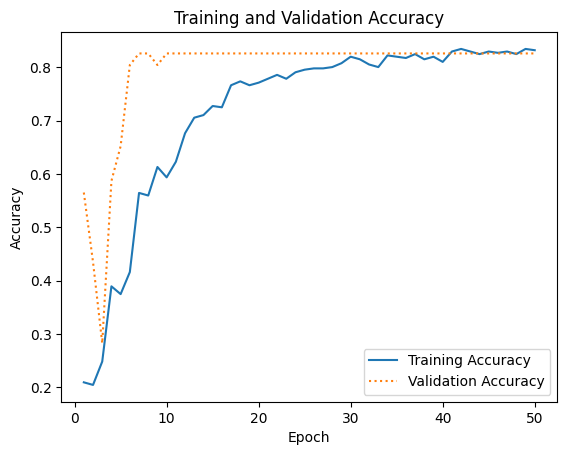

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

In [ ]:

import numpy as np
import librosa
from google.colab import files

def audio_to_mel(audio, sr=16000, n_mels=224):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mel_resized = librosa.util.fix_length(mel_spec_db, size=224, axis=1)

    mel_resized = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min())

    mel_rgb = np.stack([mel_resized, mel_resized, mel_resized], axis=-1)
    return mel_rgb

def predict_live(model):
    print("📤 Upload a .wav audio file:")
    uploaded = files.upload()
    audio_path = list(uploaded.keys())[0]

    audio, sr = librosa.load(audio_path, sr=16000)

    mel_img = audio_to_mel(audio, sr=sr)
    mel_input = np.expand_dims(mel_img, axis=0)

    output = model(mel_input, training=False)

    if isinstance(output, dict):
        if 'logits' in output:
            preds = output['logits'].numpy()
        else:
            preds = list(output.values())[0].numpy()
    else:
        preds = output.numpy()

    if preds.ndim == 1:
        class_idx = np.argmax(preds)
    else:
        class_idx = np.argmax(preds, axis=1)[0]

    print(f"🎯 Predicted class: {class_idx}, Confidence: {np.max(preds):.2f}")
    return class_idx, preds


In [ ]:
class_idx, preds = predict_live(model)
class_labels = {
    0: "belly_pain",
    1: "burping",
    2: "discomfort",
    3: "hungry",
    4: "tired"
}
print(f"Predicted class: {class_labels[class_idx]}, Confidence: {np.max(preds):.2f}")

📤 Upload a .wav audio file:


Saving 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav to 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav
🎯 Predicted class: 3, Confidence: 0.30
Predicted class: hungry, Confidence: 0.30
